In [1]:
import pandas as pd
import nltk
import spacy
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string

In [13]:
# Load the dataset
df = pd.read_csv('answers.csv')

In [3]:
# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
# Initialize SpaCy and NLTK tools
nlp = spacy.load('en_core_web_sm')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [14]:
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text.lower())
    # Stop words removal and punctuation removal
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    # Stemming
    stemmed = [stemmer.stem(word) for word in tokens]
    # Lemmatization
    lemmatized = [lemmatizer.lemmatize(word) for word in stemmed]
    return ' '.join(lemmatized)

df['processed_answer'] = df['answer'].apply(preprocess_text)

In [17]:
from gensim.models import Word2Vec
import numpy as np

# Tokenize the processed answers for Word2Vec
tokenized_answers = df['processed_answer'].apply(word_tokenize)

# CBOW model
w2v_model_cbow = Word2Vec(tokenized_answers, vector_size=100, window=5, min_count=1, sg=0)

# Skip Gram model
w2v_model_sg = Word2Vec(tokenized_answers, vector_size=100, window=5, min_count=1, sg=1)

# Function to create document vectors by averaging word vectors
def document_vector(model, doc):
    # Remove out-of-vocabulary words
    doc = [word for word in doc if word in model.wv.index_to_key]
    if len(doc) == 0:  # Handle empty documents
        return np.zeros(model.vector_size)
    return np.mean(model.wv[doc], axis=0)

# Create document vectors for each answer
df['vector_cbow'] = df['processed_answer'].apply(lambda x: document_vector(w2v_model_cbow, x.split()))
df['vector_sg'] = df['processed_answer'].apply(lambda x: document_vector(w2v_model_sg, x.split()))


In [18]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Bag of Words
vectorizer_bow = CountVectorizer()
X_bow = vectorizer_bow.fit_transform(df['processed_answer'])

# TF-IDF
vectorizer_tfidf = TfidfVectorizer()
X_tfidf = vectorizer_tfidf.fit_transform(df['processed_answer'])


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Target variable
y = df['score']

# Document vectors (CBOW)
X_cbow = np.vstack(df['vector_cbow'].values)

# Document vectors (Skip Gram)
X_sg = np.vstack(df['vector_sg'].values)

# Split the dataset
X_train_cbow, X_test_cbow, y_train, y_test = train_test_split(X_cbow, y, test_size=0.2, random_state=42)
X_train_sg, X_test_sg, y_train, y_test = train_test_split(X_sg, y, test_size=0.2, random_state=42)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


In [20]:
# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return mse, rmse

# Models
svr = SVR()
lr = LinearRegression()
dt = DecisionTreeRegressor()

# Evaluation results
results = {}

# SVR with TF-IDF
results['SVR_TFIDF'] = evaluate_model(svr, X_train_tfidf, X_test_tfidf, y_train, y_test)

# Linear Regression with TF-IDF
results['LR_TFIDF'] = evaluate_model(lr, X_train_tfidf, X_test_tfidf, y_train, y_test)

# Decision Tree with TF-IDF
results['DT_TFIDF'] = evaluate_model(dt, X_train_tfidf, X_test_tfidf, y_train, y_test)

# SVR with CBOW
results['SVR_CBOW'] = evaluate_model(svr, X_train_cbow, X_test_cbow, y_train, y_test)

# Linear Regression with CBOW
results['LR_CBOW'] = evaluate_model(lr, X_train_cbow, X_test_cbow, y_train, y_test)

# Decision Tree with CBOW
results['DT_CBOW'] = evaluate_model(dt, X_train_cbow, X_test_cbow, y_train, y_test)

# SVR with Skip Gram
results['SVR_SG'] = evaluate_model(svr, X_train_sg, X_test_sg, y_train, y_test)

# Linear Regression with Skip Gram
results['LR_SG'] = evaluate_model(lr, X_train_sg, X_test_sg, y_train, y_test)

# Decision Tree with Skip Gram
results['DT_SG'] = evaluate_model(dt, X_train_sg, X_test_sg, y_train, y_test)

# SVR with BOW
results['SVR_BOW'] = evaluate_model(svr, X_train_bow, X_test_bow, y_train, y_test)

# Linear Regression with BOW
results['LR_BOW'] = evaluate_model(lr, X_train_bow, X_test_bow, y_train, y_test)

# Decision Tree with BOW
results['DT_BOW'] = evaluate_model(dt, X_train_bow, X_test_bow, y_train, y_test)

# Print results
for model_name, (mse, rmse) in results.items():
    print(f'{model_name} - MSE: {mse}, RMSE: {rmse}')


SVR_TFIDF - MSE: 0.9578319166703098, RMSE: 0.9786888763393143
LR_TFIDF - MSE: 2.6743977215130146, RMSE: 1.6353585911086945
DT_TFIDF - MSE: 1.6899386688461908, RMSE: 1.2999764108806708
SVR_CBOW - MSE: 1.7285011135388466, RMSE: 1.314724729188147
LR_CBOW - MSE: 1.297470095544115, RMSE: 1.1390654483145888
DT_CBOW - MSE: 1.8476146046353104, RMSE: 1.3592698792496325
SVR_SG - MSE: 1.4878150686560525, RMSE: 1.219760250482058
LR_SG - MSE: 1.2330022721885734, RMSE: 1.1104063545335885
DT_SG - MSE: 1.735456247265366, RMSE: 1.3173671649412575
SVR_BOW - MSE: 1.1195749086816102, RMSE: 1.0580996685953599
LR_BOW - MSE: 5.19836720718441, RMSE: 2.279992808581731
DT_BOW - MSE: 1.657381258548101, RMSE: 1.2873932027737682


In [27]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

# SVR with TF-IDF
svr.fit(X_train_tfidf, y_train)
y_pred_tfidf = svr.predict(X_test_tfidf)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred_tfidf)

# R-squared (R²)
r2 = r2_score(y_test, y_pred_tfidf)

# Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred_tfidf)

# Print the additional evaluation metrics
print(f'SVR with TF-IDF - MAE: {mae}')
print(f'SVR with TF-IDF - R²: {r2}')
print(f'SVR with TF-IDF - MAPE: {mape}')


SVR with TF-IDF - MAE: 0.6883418244004517
SVR with TF-IDF - R²: 0.25113535012485055
SVR with TF-IDF - MAPE: 20257173748297.2


In [28]:
# Function to evaluate models with additional metrics
def extended_evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    return mse, rmse, mae, r2, mape

# Extended evaluation results
extended_results = {}

# Models
svr = SVR()
lr = LinearRegression()
dt = DecisionTreeRegressor()

# SVR with TF-IDF
extended_results['SVR_TFIDF'] = extended_evaluate_model(svr, X_train_tfidf, X_test_tfidf, y_train, y_test)

# Linear Regression with TF-IDF
extended_results['LR_TFIDF'] = extended_evaluate_model(lr, X_train_tfidf, X_test_tfidf, y_train, y_test)

# Decision Tree with TF-IDF
extended_results['DT_TFIDF'] = extended_evaluate_model(dt, X_train_tfidf, X_test_tfidf, y_train, y_test)

# SVR with CBOW
extended_results['SVR_CBOW'] = extended_evaluate_model(svr, X_train_cbow, X_test_cbow, y_train, y_test)

# Linear Regression with CBOW
extended_results['LR_CBOW'] = extended_evaluate_model(lr, X_train_cbow, X_test_cbow, y_train, y_test)

# Decision Tree with CBOW
extended_results['DT_CBOW'] = extended_evaluate_model(dt, X_train_cbow, X_test_cbow, y_train, y_test)

# SVR with Skip Gram
extended_results['SVR_SG'] = extended_evaluate_model(svr, X_train_sg, X_test_sg, y_train, y_test)

# Linear Regression with Skip Gram
extended_results['LR_SG'] = extended_evaluate_model(lr, X_train_sg, X_test_sg, y_train, y_test)

# Decision Tree with Skip Gram
extended_results['DT_SG'] = extended_evaluate_model(dt, X_train_sg, X_test_sg, y_train, y_test)

# SVR with Bag of Words
extended_results['SVR_BOW'] = extended_evaluate_model(svr, X_train_bow, X_test_bow, y_train, y_test)

# Linear Regression with Bag of Words
extended_results['LR_BOW'] = extended_evaluate_model(lr, X_train_bow, X_test_bow, y_train, y_test)

# Decision Tree with Bag of Words
extended_results['DT_BOW'] = extended_evaluate_model(dt, X_train_bow, X_test_bow, y_train, y_test)

# Print extended results
for model_name, (mse, rmse, mae, r2, mape) in extended_results.items():
    print(f'{model_name} - MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R²: {r2}, MAPE: {mape}')


SVR_TFIDF - MSE: 0.9578319166703098, RMSE: 0.9786888763393143, MAE: 0.6883418244004517, R²: 0.25113535012485055, MAPE: 20257173748297.2
LR_TFIDF - MSE: 2.6743977215130146, RMSE: 1.6353585911086945, MAE: 1.177089464435463, R²: -1.0909325305319735, MAPE: 14977548280677.408
DT_TFIDF - MSE: 1.6450595304119962, RMSE: 1.2825987409989128, MAE: 0.8209703214304441, R²: -0.28616191194408924, MAPE: 3683926075558.9683
SVR_CBOW - MSE: 1.7285011135388466, RMSE: 1.314724729188147, MAE: 0.8818618972342236, R²: -0.3513992994708459, MAPE: 76921815909941.22
LR_CBOW - MSE: 1.297470095544115, RMSE: 1.1390654483145888, MAE: 0.8712143919393056, R²: -0.014405003542557582, MAPE: 23533019349638.086
DT_CBOW - MSE: 1.8229099509690698, RMSE: 1.350151825154886, MAE: 0.913893536592923, R²: -0.42521124889207096, MAPE: 3683926075558.9956
SVR_SG - MSE: 1.4878150686560525, RMSE: 1.219760250482058, MAE: 0.8266748441323549, R²: -0.16322299463694878, MAPE: 81750020933860.05
LR_SG - MSE: 1.2330022721885734, RMSE: 1.11040635

In [29]:
# Function to evaluate models with additional metrics
def extended_evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    return mse, rmse, mae, r2, mape

# Extended evaluation results
extended_results = {}

# Models
svr = SVR()
lr = LinearRegression()
dt = DecisionTreeRegressor()

# SVR with TF-IDF
extended_results['SVR_TFIDF'] = extended_evaluate_model(svr, X_train_tfidf, X_test_tfidf, y_train, y_test)

# Linear Regression with TF-IDF
extended_results['LR_TFIDF'] = extended_evaluate_model(lr, X_train_tfidf, X_test_tfidf, y_train, y_test)

# Decision Tree with TF-IDF
extended_results['DT_TFIDF'] = extended_evaluate_model(dt, X_train_tfidf, X_test_tfidf, y_train, y_test)

# SVR with CBOW
extended_results['SVR_CBOW'] = extended_evaluate_model(svr, X_train_cbow, X_test_cbow, y_train, y_test)

# Linear Regression with CBOW
extended_results['LR_CBOW'] = extended_evaluate_model(lr, X_train_cbow, X_test_cbow, y_train, y_test)

# Decision Tree with CBOW
extended_results['DT_CBOW'] = extended_evaluate_model(dt, X_train_cbow, X_test_cbow, y_train, y_test)

# SVR with Skip Gram
extended_results['SVR_SG'] = extended_evaluate_model(svr, X_train_sg, X_test_sg, y_train, y_test)

# Linear Regression with Skip Gram
extended_results['LR_SG'] = extended_evaluate_model(lr, X_train_sg, X_test_sg, y_train, y_test)

# Decision Tree with Skip Gram
extended_results['DT_SG'] = extended_evaluate_model(dt, X_train_sg, X_test_sg, y_train, y_test)

# SVR with Bag of Words
extended_results['SVR_BOW'] = extended_evaluate_model(svr, X_train_bow, X_test_bow, y_train, y_test)

# Linear Regression with Bag of Words
extended_results['LR_BOW'] = extended_evaluate_model(lr, X_train_bow, X_test_bow, y_train, y_test)

# Decision Tree with Bag of Words
extended_results['DT_BOW'] = extended_evaluate_model(dt, X_train_bow, X_test_bow, y_train, y_test)

# Print extended results
for model_name, (mse, rmse, mae, r2, mape) in extended_results.items():
    print(f'{model_name} - MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R²: {r2}, MAPE: {mape}')


SVR_TFIDF - MSE: 0.9578319166703098, RMSE: 0.9786888763393143, MAE: 0.6883418244004517, R²: 0.25113535012485055, MAPE: 20257173748297.2
LR_TFIDF - MSE: 2.6743977215130146, RMSE: 1.6353585911086945, MAE: 1.177089464435463, R²: -1.0909325305319735, MAPE: 14977548280677.408
DT_TFIDF - MSE: 1.7020361749267077, RMSE: 1.3046210848084234, MAE: 0.8378398484610141, R²: -0.3307081357678845, MAPE: 3683926075558.971
SVR_CBOW - MSE: 1.7285011135388466, RMSE: 1.314724729188147, MAE: 0.8818618972342236, R²: -0.3513992994708459, MAPE: 76921815909941.22
LR_CBOW - MSE: 1.297470095544115, RMSE: 1.1390654483145888, MAE: 0.8712143919393056, R²: -0.014405003542557582, MAPE: 23533019349638.086
DT_CBOW - MSE: 1.8217596442206037, RMSE: 1.349725766302401, MAE: 0.9150864472950363, R²: -0.4243119010571881, MAPE: 3683926075558.9937
SVR_SG - MSE: 1.4878150686560525, RMSE: 1.219760250482058, MAE: 0.8266748441323549, R²: -0.16322299463694878, MAPE: 81750020933860.05
LR_SG - MSE: 1.2330022721885734, RMSE: 1.1104063545

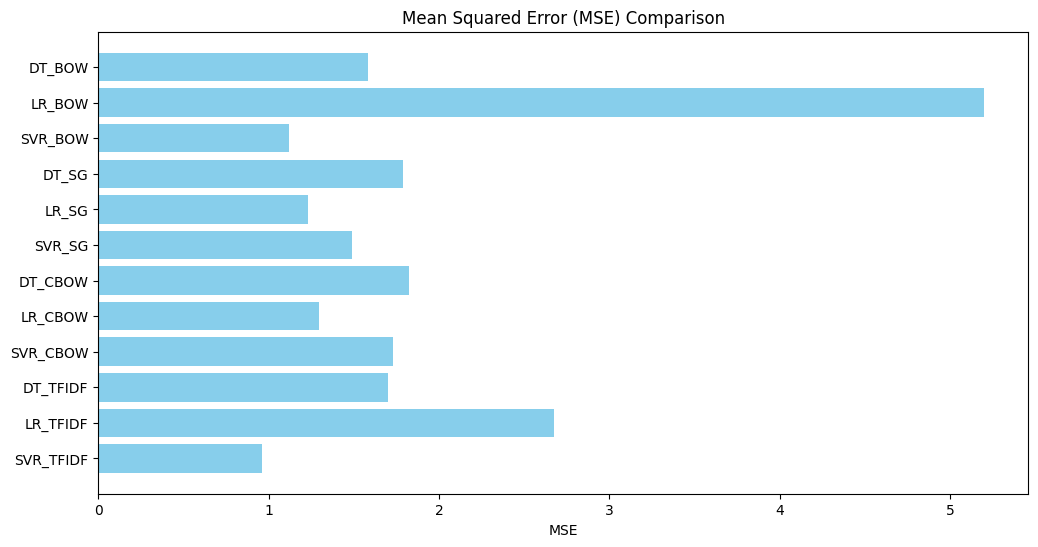

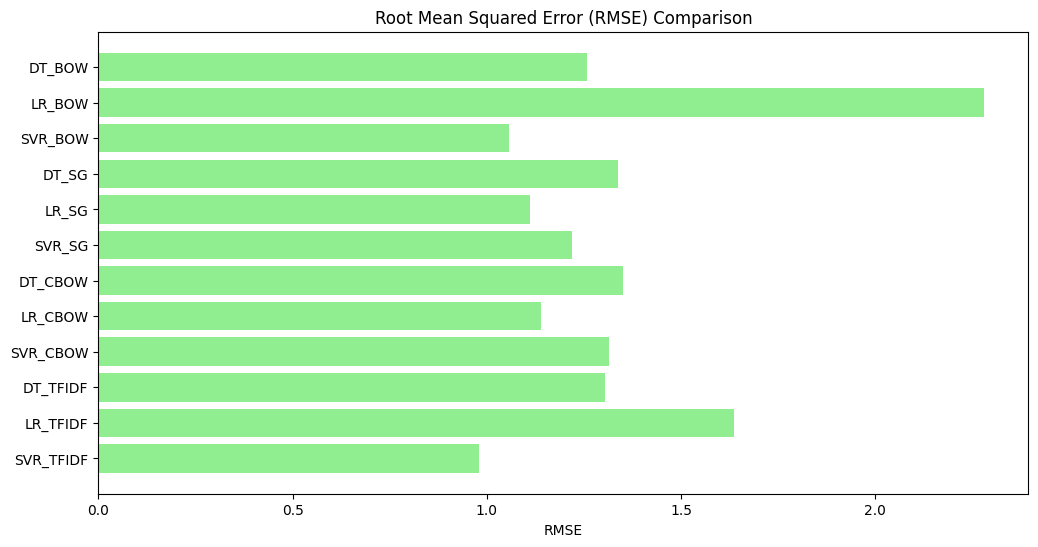

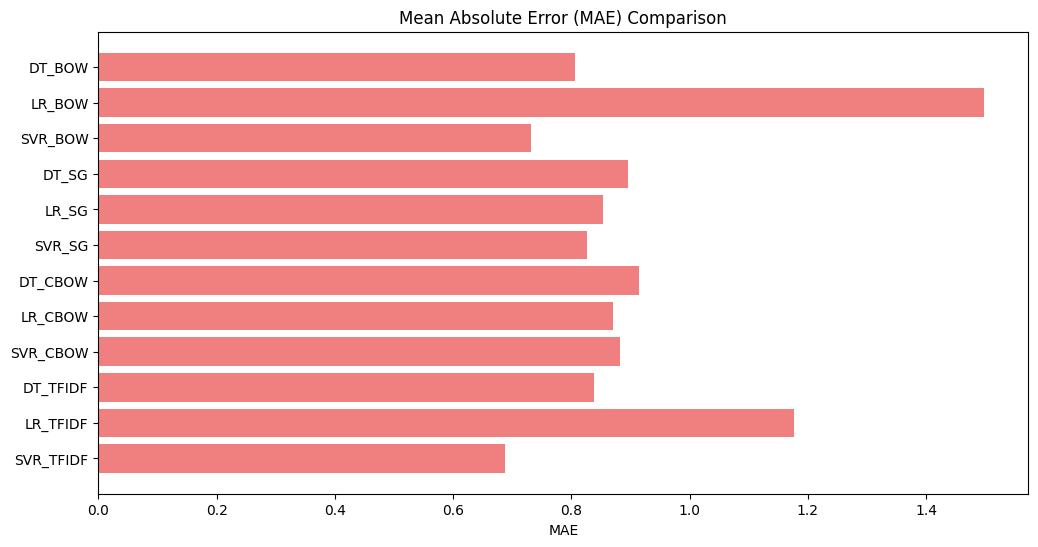

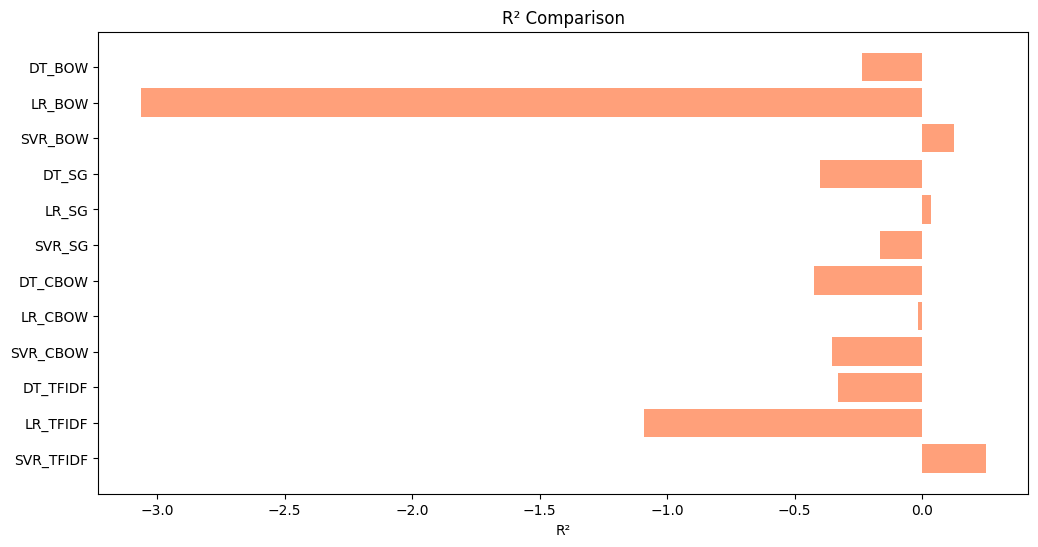

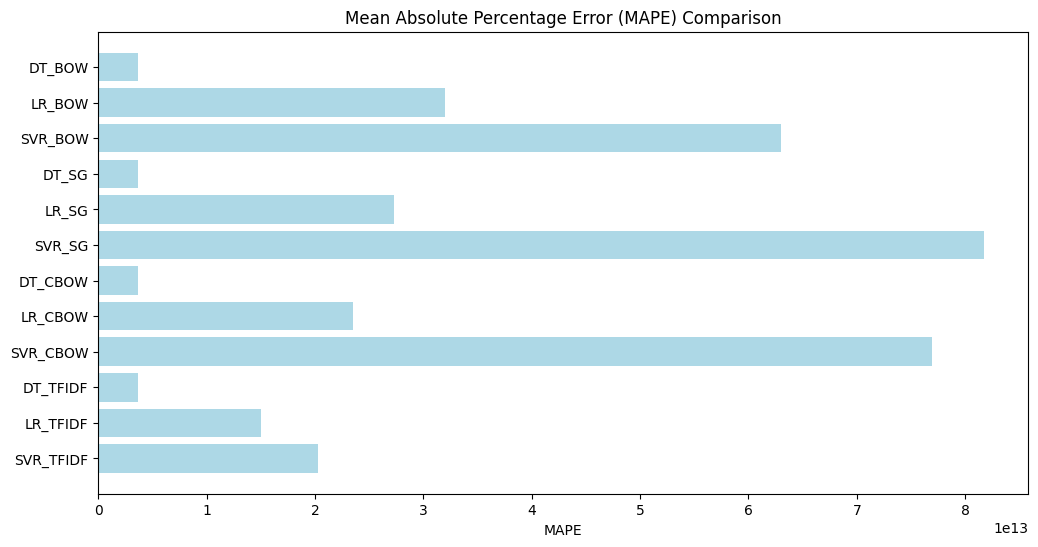

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Extract metrics for plotting
models = list(extended_results.keys())
mse_values = [extended_results[model][0] for model in models]
rmse_values = [extended_results[model][1] for model in models]
mae_values = [extended_results[model][2] for model in models]
r2_values = [extended_results[model][3] for model in models]
mape_values = [extended_results[model][4] for model in models]

# Plot MSE
plt.figure(figsize=(12, 6))
plt.barh(models, mse_values, color='skyblue')
plt.xlabel('MSE')
plt.title('Mean Squared Error (MSE) Comparison')
plt.show()

# Plot RMSE
plt.figure(figsize=(12, 6))
plt.barh(models, rmse_values, color='lightgreen')
plt.xlabel('RMSE')
plt.title('Root Mean Squared Error (RMSE) Comparison')
plt.show()

# Plot MAE
plt.figure(figsize=(12, 6))
plt.barh(models, mae_values, color='lightcoral')
plt.xlabel('MAE')
plt.title('Mean Absolute Error (MAE) Comparison')
plt.show()

# Plot R²
plt.figure(figsize=(12, 6))
plt.barh(models, r2_values, color='lightsalmon')
plt.xlabel('R²')
plt.title('R² Comparison')
plt.show()

# Plot MAPE
plt.figure(figsize=(12, 6))
plt.barh(models, mape_values, color='lightblue')
plt.xlabel('MAPE')
plt.title('Mean Absolute Percentage Error (MAPE) Comparison')
plt.show()
